# Simple integrator - state an control constraints

Minimise

$$
    \int_{0}^{3} \exp(-\alpha t)\, u(t) \, \mathrm{d}t
$$

subject to the constraints

$$
    \dot x(t) = u(t), \quad 0 \le u(t) \le 3, \quad 1-x(t)-(t-2)^2 \leq 0
$$

and the limit conditions

$$
    x(0) = 0.
$$

## Direct method

In [1]:
# For direct methods
using JuMP, Ipopt
# To plot solutions
using Plots

In [4]:
# Create JuMP model, using Ipopt as the solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
set_optimizer_attribute(sys,"max_iter",1000)

# Parameters
α = 1
t0 = 0    # initial time
tf = 3    # final time
c0 = 0    # Initial cost
x0 = 0    # Initial position

N  = 50    # Grid size
Δt = (tf-t0)/N  # Time step

t = range(t0, tf, length=N+1)  # Time grid

@variables(sys, begin
    c[1:N+1]    # Cost
    x[1:N+1]    # State
    0 ≤ u[1:N+1] ≤ 3    # Control
end)

# Objective
@objective(sys, Min, c[N+1])

# Boundary constraints
@constraints(sys, begin
    con_c0, c[1] - c0 == 0
    con_x0, x[1] - x0 == 0
end)

@NLexpressions(sys, begin
    f0[i = 1:N+1], exp(-α * t[i]) * u[i] + 1e-3 * u[i]^2
end)

# Dynamics with Crank-Nicolson scheme
@NLconstraints(sys, begin
    con_dc[j=1:N], c[j+1] == c[j] + 0.5 * Δt * (f0[j+1] + f0[j])
    con_dx[j=1:N], x[j+1] == x[j] + 0.5 * Δt * ( u[j+1] +  u[j])
    path_con[j=1:N], 1-x[j]-(t[j]-2)^2 ≤ 0
end);

In [5]:
# Solve for the control and state
println("Solving...")
optimize!(sys)
println()

# Display results
if termination_status(sys) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(sys))
println()

# Retrieves values (including duals)
c = value.(c)[:]
x = value.(x)[:]
u = value.(u)[:]
t = (0:N) * value.(Δt)

pc0 = dual(con_c0)
px0 = dual(con_x0)

if(pc0*dual(con_dc[1])<0); pc0 = -pc0; end
if(px0*dual(con_dx[1])<0); px0 = -px0; end

if (pc0 > 0) # Sign convention according to Pontryagin Maximum Principle
    sign = -1.0
else
    sign =  1.0
end

pc = [ dual(con_dc[i]) for i in 1:N ]
px = [ dual(con_dx[i]) for i in 1:N ]

pc = sign * [pc0; pc[1:N]] 
px = sign * [px0; (px[1:N-1]+px[2:N])/2; 0];

Solving...


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:      402
Number of nonzeros in inequality constraint Jacobian.:       50
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      153
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       51
                     variables with only upper bounds:        0
Total number of equality constraints.................:      102
Total number of inequality constraints...............:       50
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       50

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 4.38e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

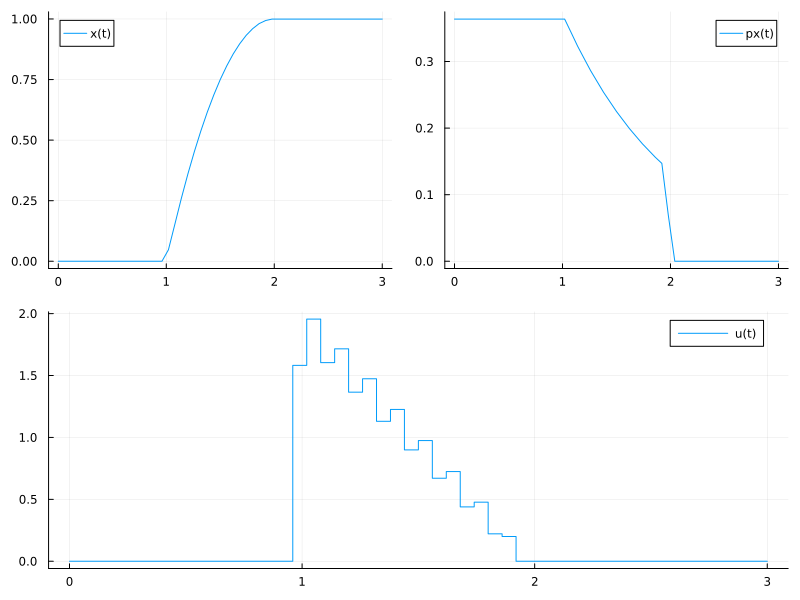

In [6]:
x_plot = plot(t, x, label="x(t)")
px_plot = plot(t, px, label="px(t)")
u_plot = plot(t, u, label="u(t)", linetype=:steppre)

pxp_plot = plot(x_plot, px_plot, layout=(1,2))
l = @layout [a{0.5h}
            b]
plot(pxp_plot, u_plot, layout=l, size=(800,600))